# Convert SnowMIP forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## BERMS Old Aspen, Saskatchewan, Canada

Even-aged stand of aspen with a thick hazelnut understorey, naturally regenerated after
fire in 1919. 10 cm layer of organic litter and peat over a sandy clay loam.

| Short name | oas |
|:-----------|:----|
| Location | 53.63ºN, 106.20ºW |
| Elevation | 600 m |
| Canopy height | 21 m |
| Leaf area index | winter stem area ~1, summer 3.7 – 5.2 |
| Snow-free albedo | 0.14 |
| Simulation period | 1 October 1997 to 30 September 2010 |
| Temperature/humidity measurement height | 37 m |
| Wind measurement height | 38 m |
| Reference | Bartlett et al. (2007) |

In [16]:
site = 'oas'
site_longname = 'BERMS Old Aspen, Saskatchewan, Canada'

year_start = '1997'
year_end = '2010'

lat = 53.63
lon = -106.20

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/oas already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/oas/forcing already exist.


### Open original forcing file

In [3]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 113952)
Coordinates:
  * time     (time) datetime64[ns] 912kB 1997-10-01T01:00:00 ... 2010-10-01
Data variables:
    LWdown   (time) float32 456kB ...
    Psurf    (time) float32 456kB ...
    Qair     (time) float32 456kB ...
    Rainf    (time) float32 456kB ...
    Snowf    (time) float32 456kB ...
    SWdown   (time) float32 456kB ...
    Tair     (time) float32 456kB ...
    Wind     (time) float32 456kB ...

In [4]:
ds.time.encoding

{'dtype': dtype('float32'),
 'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1048576,),
 'preferred_chunks': {'time': 1048576},
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/met_insitu_oas_1997_2010.nc',
 'original_shape': (113952,),
 'units': 'hours since 1900-01-01 00:00:00.0'}

In [5]:
# Check if there are leap years
ds.sel(time='2004-02')
# ds.sel(time='2016-02')

<xarray.Dataset> Size: 28kB
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2004-02-01 ... 2004-02-29T23:00:00
Data variables:
    LWdown   (time) float32 3kB ...
    Psurf    (time) float32 3kB ...
    Qair     (time) float32 3kB ...
    Rainf    (time) float32 3kB ...
    Snowf    (time) float32 3kB ...
    SWdown   (time) float32 3kB ...
    Tair     (time) float32 3kB ...
    Wind     (time) float32 3kB ...

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [6]:
ds_30min = ds.resample(time='30min').interpolate()
ds_30min

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 227903)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1997-10-01T01:00:00 ... 2010-10-01
Data variables:
    LWdown   (time) float64 2MB 342.4 342.6 342.9 338.1 ... 261.0 261.1 261.2
    Psurf    (time) float64 2MB 9.312e+04 9.306e+04 ... 9.555e+04 9.559e+04
    Qair     (time) float64 2MB 0.004715 0.00481 0.004905 ... 0.005368 0.00545
    Rainf    (time) float64 2MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Snowf    (time) float64 2MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SWdown   (time) float64 2MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Tair     (time) float64 2MB 285.9 285.9 286.0 286.2 ... 281.1 281.0 280.9
    Wind     (time) float64 2MB 3.8 3.8 3.8 3.75 3.7 ... 2.7 2.65 2.6 2.65 2.7

## Check that after interpolation the cumulated precip (in mm/year) is reasonably conserved

In [7]:
ds.Snowf.sum()*3600*24/365

<xarray.DataArray 'Snowf' ()> Size: 8B
array(104.98248505)

In [8]:
ds_30min.Snowf.sum()*3600*24/365/2

<xarray.DataArray 'Snowf' ()> Size: 8B
array(104.98247456)

In [9]:
ds.Rainf.sum()*3600*24/365

<xarray.DataArray 'Rainf' ()> Size: 8B
array(315.22982872)

In [10]:
ds_30min.Rainf.sum()*3600*24/365/2

<xarray.DataArray 'Rainf' ()> Size: 8B
array(315.2298665)

### Extend beginning and the end of the forcing
Because CLASSIC only accept full years (will need to be removed for analyses)

In [11]:
time_ext = pd.date_range(
    pd.to_datetime(ds_30min.time.dt.year[0], format='%Y'), 
    str(ds_30min.time.dt.year[-1].values.item(0))+'-12-31 23:30:00',
    freq='30min'
)
time_ext

DatetimeIndex(['1997-01-01 00:00:00', '1997-01-01 00:30:00',
               '1997-01-01 01:00:00', '1997-01-01 01:30:00',
               '1997-01-01 02:00:00', '1997-01-01 02:30:00',
               '1997-01-01 03:00:00', '1997-01-01 03:30:00',
               '1997-01-01 04:00:00', '1997-01-01 04:30:00',
               ...
               '2010-12-31 19:00:00', '2010-12-31 19:30:00',
               '2010-12-31 20:00:00', '2010-12-31 20:30:00',
               '2010-12-31 21:00:00', '2010-12-31 21:30:00',
               '2010-12-31 22:00:00', '2010-12-31 22:30:00',
               '2010-12-31 23:00:00', '2010-12-31 23:30:00'],
              dtype='datetime64[ns]', length=245424, freq='30T')

In [12]:
ds_30min_ext = ds_30min.reindex(time=time_ext)
ds_30min_ext

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 245424)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1997-01-01 ... 2010-12-31T23:30:00
Data variables:
    LWdown   (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Psurf    (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Qair     (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Rainf    (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Snowf    (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    SWdown   (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Tair     (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan
    Wind     (time) float64 2MB nan nan nan nan nan nan ... nan nan nan nan nan

In [13]:
# ds_30min    : XXXXXXXXXXXXXXXXXXXXXXXXXXXX........... i_start_next_year ....... i_end_next_year
# ds_30min_ext: 1rst jan .... i_before_start

i_before_start = ds_30min_ext.sel(time=slice(None,ds_30min.time[0])).time.size - 1 
i_start_next_year = ds_30min.sel(time=slice(None, year_start)).time.size
i_end_next_year = i_start_next_year + i_before_start

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][:i_before_start].size,
    ds_30min['Wind'][i_start_next_year:i_end_next_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][:i_before_start] = ds_30min[key][i_start_next_year:i_end_next_year].values

In [14]:
# ds_30min    : i_start_prev_year ....... i_end_prev_year.......XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# ds_30min_ext: ............................................... i_after_end.......... 31 dec

i_after_end = ds_30min_ext.sel(time=slice(ds_30min.time[-1]+1, None)).time.size
i_end_prev_year = ds_30min.time.sel(time=slice(year_end, None)).time.size
i_start_prev_year = i_end_prev_year + i_after_end

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][-i_after_end:].size,
    ds_30min['Wind'][-i_start_prev_year:-i_end_prev_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][-i_after_end:] = ds_30min[key][-i_start_prev_year:-i_end_prev_year].values

Text(0.5, 0.98, 'BERMS Old Aspen, Saskatchewan, Canada')

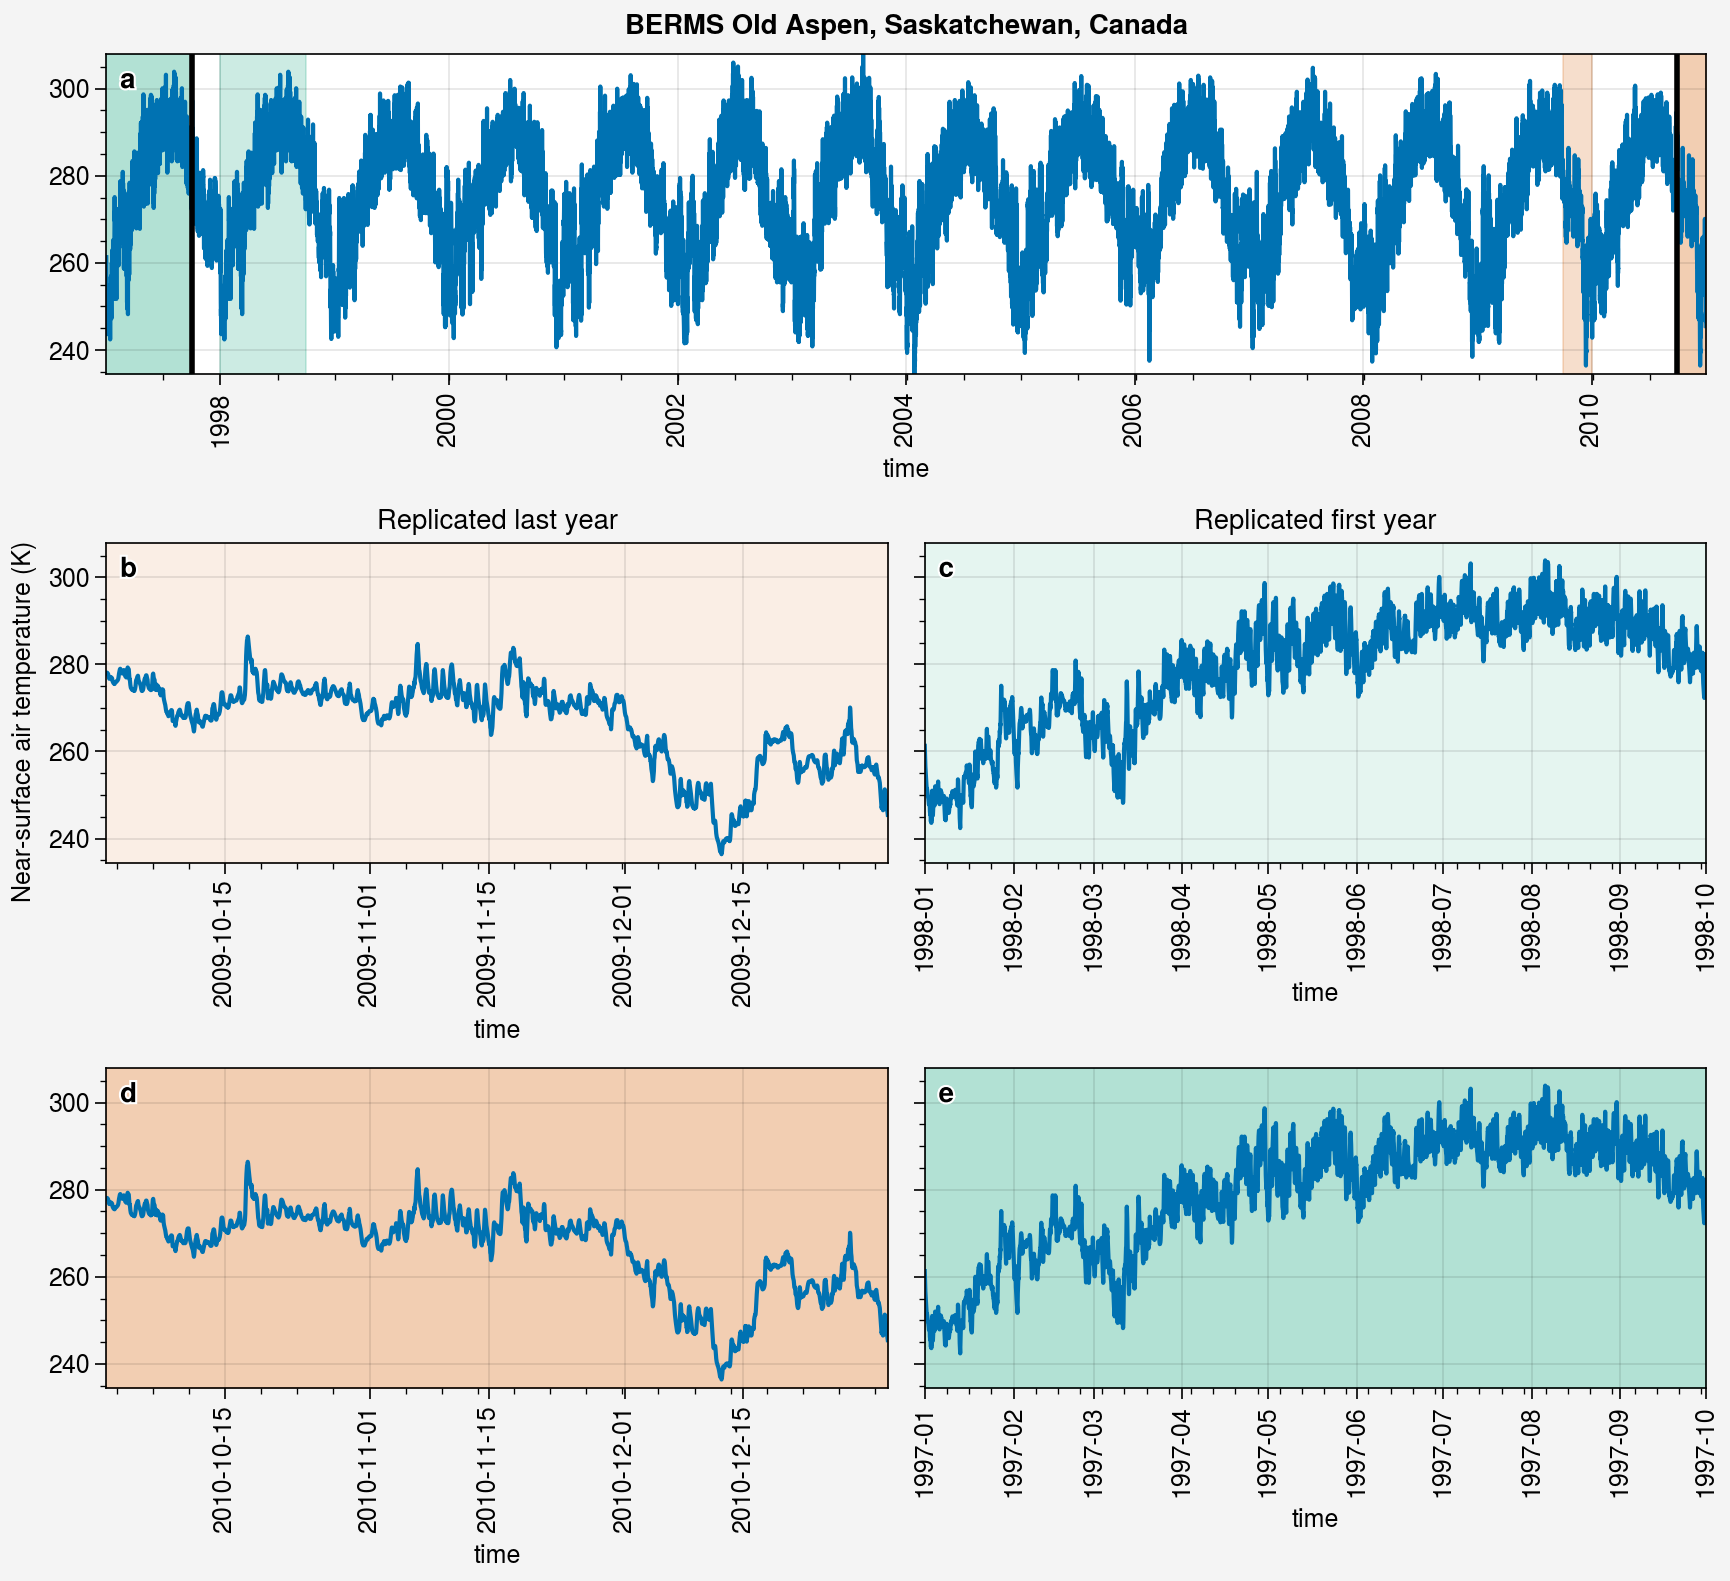

In [17]:
%matplotlib inline
fig, axs = pplt.subplots([[1, 1], [2, 3], [4, 5]], refaspect=5, refwidth=8, sharex=0)

key = 'Tair'

axs[0].plot(ds_30min_ext[key])

axs[0].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.2
)

axs[0].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.2
)

axs[0].axvline(ds_30min[key][0].time.values, lw=2, ls='-', color='k')
axs[0].axvline(ds_30min[key][-1].time.values, lw=2, ls='-', color='k')

axs[2].format(title='Replicated first year')
axs[4].plot(ds_30min_ext[key][:i_before_start])
axs[4].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)
axs[2].plot(ds_30min[key][i_start_next_year:i_end_next_year])
axs[2].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[1].format(title='Replicated last year')
axs[3].plot(ds_30min_ext[key][-i_after_end:])
axs[3].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)
axs[1].plot(ds_30min[key][-i_start_prev_year:-i_end_prev_year])
axs[1].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs.format(abc=True, abcloc='ul')
fig.suptitle(site_longname)


### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [18]:
ds_30min_ext.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'.nc')

In [19]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}.nc {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 1963392 values from 8 variables over 245424 timesteps [35.36s 643MB]


## Open the new file with absolute time

In [20]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_a.nc')
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 245424)
Coordinates:
  * time     (time) float64 2MB 1.997e+07 1.997e+07 ... 2.01e+07 2.01e+07
Data variables:
    LWdown   (time) float64 2MB ...
    Psurf    (time) float64 2MB ...
    Qair     (time) float64 2MB ...
    Rainf    (time) float64 2MB ...
    Snowf    (time) float64 2MB ...
    SWdown   (time) float64 2MB ...
    Tair     (time) float64 2MB ...
    Wind     (time) float64 2MB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 08 15:04:00 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [21]:
ds.time

<xarray.DataArray 'time' (time: 245424)> Size: 2MB
array([19970101.      , 19970101.020833, 19970101.041667, ..., 20101231.9375  ,
       20101231.958333, 20101231.979167])
Coordinates:
  * time     (time) float64 2MB 1.997e+07 1.997e+07 ... 2.01e+07 2.01e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [22]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 245424, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 2MB 1.997e+07 1.997e+07 ... 2.01e+07 2.01e+07
  * lon      (lon) float64 8B -106.2
  * lat      (lat) float64 8B 53.63
Data variables:
    LWdown   (time, lat, lon) float64 2MB 269.3 265.6 261.9 ... 129.2 129.6
    Psurf    (time, lat, lon) float64 2MB 9.305e+04 9.313e+04 ... 9.605e+04
    Qair     (time, lat, lon) float64 2MB 0.001385 0.001315 ... 0.0003028
    Rainf    (time, lat, lon) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 2MB 0.0003143 0.0001572 0.0 ... 0.0 0.0
    SWdown   (time, lat, lon) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair     (time, lat, lon) float64 2MB 261.3 260.8 260.2 ... 245.7 245.4
    Wind     (time, lat, lon) float64 2MB 4.6 4.7 4.8 4.2 ... 2.6 2.2 1.8 2.25
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 08 15:04:00 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

### Convert temperature to °C (<mark>required by CLASSIC</mark>)

In [23]:
with xr.set_options(keep_attrs=True):
    ds['Tair'] = ds['Tair'] - 273.15
    ds.Tair.attrs['units'] = '°C'
ds.Tair

<xarray.DataArray 'Tair' (time: 245424, lat: 1, lon: 1)> Size: 2MB
array([[[-11.85001221]],

       [[-12.4       ]],

       [[-12.94998779]],

       ...,

       [[-27.10000458]],

       [[-27.45000305]],

       [[-27.70000305]]])
Coordinates:
  * time     (time) float64 2MB 1.997e+07 1.997e+07 ... 2.01e+07 2.01e+07
  * lon      (lon) float64 8B -106.2
  * lat      (lat) float64 8B 53.63
Attributes:
    long_name:  Near-surface air temperature
    units:      °C
    ALMA_name:  Tair
    CMIP_name:  ta

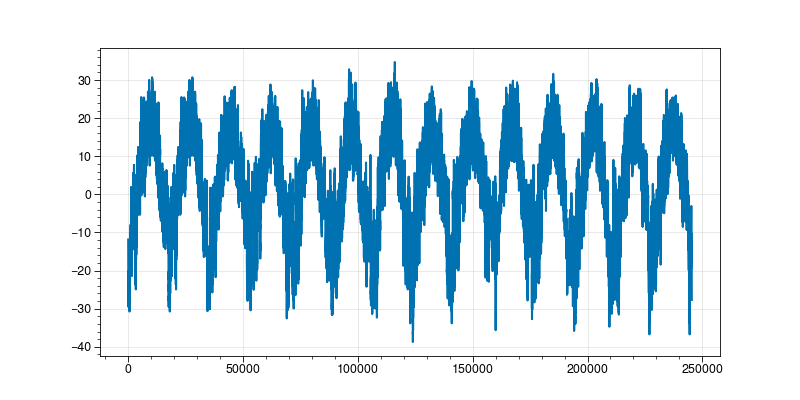

In [24]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

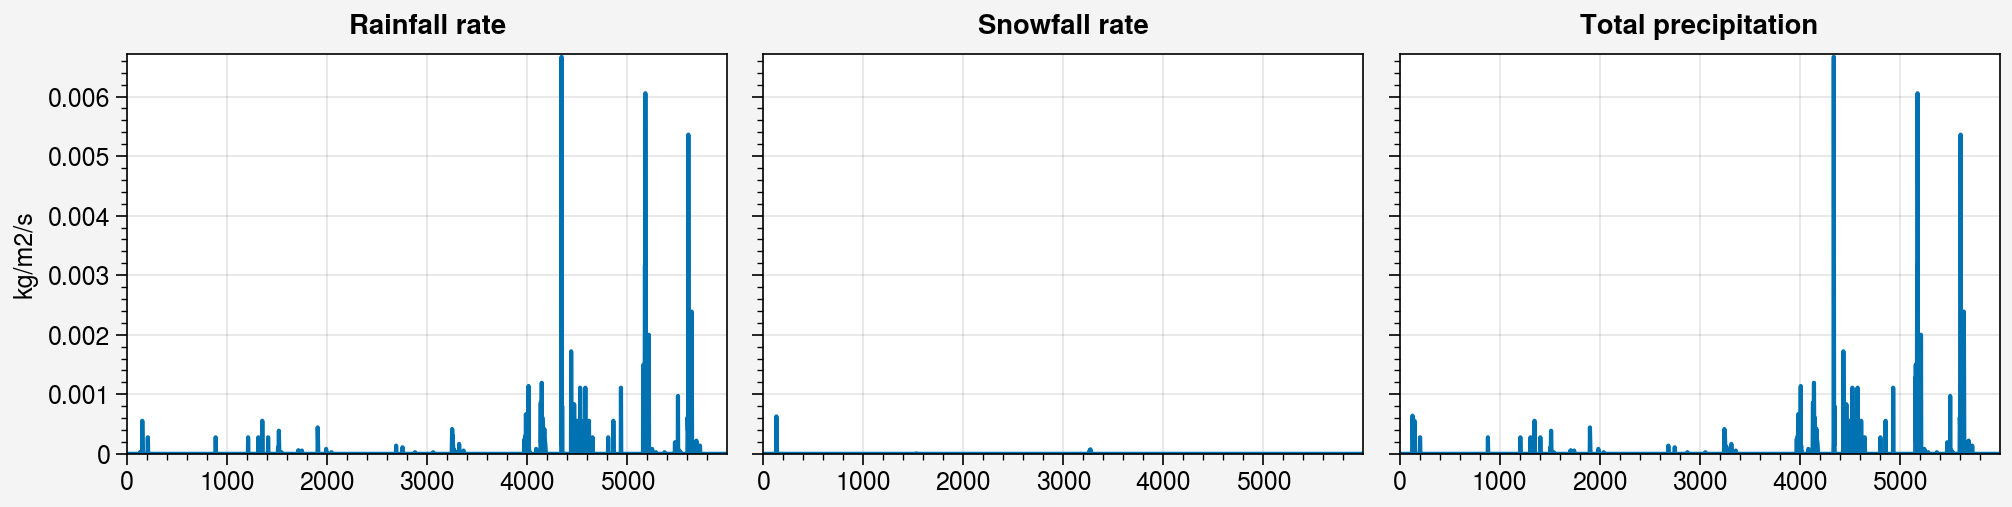

In [25]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 2000*2
i_end = 5000*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [26]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset> Size: 20MB
Dimensions:    (time: 245424, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 2MB 1.997e+07 1.997e+07 ... 2.01e+07 2.01e+07
  * lon        (lon) float64 8B -106.2
  * lat        (lat) float64 8B 53.63
Data variables:
    LWdown     (time, lat, lon) float64 2MB 269.3 265.6 261.9 ... 129.2 129.6
    Psurf      (time, lat, lon) float64 2MB 9.305e+04 9.313e+04 ... 9.605e+04
    Qair       (time, lat, lon) float64 2MB 0.001385 0.001315 ... 0.0003028
    Rainf      (time, lat, lon) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 2MB 0.0003143 0.0001572 0.0 ... 0.0 0.0
    SWdown     (time, lat, lon) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Tair       (time, lat, lon) float64 2MB -11.85 -12.4 -12.95 ... -27.45 -27.7
    Wind       (time, lat, lon) float64 2MB 4.6 4.7 4.8 4.2 ... 2.6 2.2 1.8 2.25
    TotPrecip  (time, lat, lon) float64 2MB 0.0003143 0.0001572 0.0 ... 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 08 15:04:00 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## All the procedure may introduce negative precip values due to computing precision so replace them by 0

In [27]:
ds.Snowf.where(ds.Snowf < 0).sum()

<xarray.DataArray 'Snowf' ()> Size: 8B
array(-1.06408514e-18)

In [28]:
ds.Rainf.where(ds.Rainf < 0).sum()

<xarray.DataArray 'Rainf' ()> Size: 8B
array(-4.76837198e-18)

In [29]:
ds.TotPrecip.where(ds.TotPrecip < 0).sum()

<xarray.DataArray 'TotPrecip' ()> Size: 8B
array(-5.80281096e-18)

In [30]:
ds['Rainf'] = ds.Rainf.where(ds.Rainf > 0, other=0)
ds['Snowf'] = ds.Snowf.where(ds.Snowf > 0, other=0)
ds['TotPrecip'] = ds.TotPrecip.where(ds.TotPrecip > 0, other=0)

In [31]:
np.testing.assert_equal(ds.Rainf.where(ds.Rainf < 0).sum().values, 0)
np.testing.assert_equal(ds.Snowf.where(ds.Snowf < 0).sum().values, 0)
np.testing.assert_equal(ds.TotPrecip.where(ds.TotPrecip < 0).sum().values, 0)

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [32]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')

In [33]:
!ls {path_out}

met_insitu_oas_1998_2009_LWdown.nc
met_insitu_oas_1998_2009_Psurf.nc
met_insitu_oas_1998_2009_Qair.nc
met_insitu_oas_1998_2009_Rainf.nc
met_insitu_oas_1998_2009_Snowf.nc
met_insitu_oas_1998_2009_SWdown.nc
met_insitu_oas_1998_2009_Tair.nc
met_insitu_oas_1998_2009_TotPrecip.nc
met_insitu_oas_1998_2009_Wind.nc
met_insitu_oas_30min_ext_1997_2010_LWdown.nc
met_insitu_oas_30min_ext_1997_2010_Psurf.nc
met_insitu_oas_30min_ext_1997_2010_Qair.nc
met_insitu_oas_30min_ext_1997_2010_Rainf.nc
met_insitu_oas_30min_ext_1997_2010_Snowf.nc
met_insitu_oas_30min_ext_1997_2010_SWdown.nc
met_insitu_oas_30min_ext_1997_2010_Tair.nc
met_insitu_oas_30min_ext_1997_2010_TotPrecip.nc
met_insitu_oas_30min_ext_1997_2010_Wind.nc


In [34]:
!ls {path_out_CLASSIC}

met_insitu_oas_1998_2009_LWdown.nc
met_insitu_oas_1998_2009_Psurf.nc
met_insitu_oas_1998_2009_Qair.nc
met_insitu_oas_1998_2009_Rainf.nc
met_insitu_oas_1998_2009_Snowf.nc
met_insitu_oas_1998_2009_SWdown.nc
met_insitu_oas_1998_2009_Tair.nc
met_insitu_oas_1998_2009_TotPrecip.nc
met_insitu_oas_1998_2009_Wind.nc
met_insitu_oas_30min_ext_1997_2010_LWdown.nc
met_insitu_oas_30min_ext_1997_2010_Psurf.nc
met_insitu_oas_30min_ext_1997_2010_Qair.nc
met_insitu_oas_30min_ext_1997_2010_Rainf.nc
met_insitu_oas_30min_ext_1997_2010_Snowf.nc
met_insitu_oas_30min_ext_1997_2010_SWdown.nc
met_insitu_oas_30min_ext_1997_2010_Tair.nc
met_insitu_oas_30min_ext_1997_2010_TotPrecip.nc
met_insitu_oas_30min_ext_1997_2010_Wind.nc


### Keep the same initial files from Ref run (but redo spinup)

In [35]:
path_init = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/'+site
exp = 'Ref'
exp2 = 'Ref_30min_ext'
!cp {path_init}/{site}_init_spinup_{exp}.nc {path_init}/{site}_init_spinup_{exp2}.nc
!cp {path_init}/rsfile_spinup_{exp}.nc {path_init}/rsfile_spinup_{exp2}.nc

In [36]:
!mkdir /home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/{site}/spinup_{exp2}